In [2]:
import numpy as np
import pandas as pd

# general imports
import os
from tqdm import tqdm

# graphs
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
# pytorch imports
import torch
import torch.nn as nn
from torch.autograd import Variable

# torch dataloaders
import torch.functional as f
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split

## Defining functions and NN

**`Exact solution is :`** $$\sin(\pi*(X - a*T)) $$

In [501]:
def exact(X,T,a=1):

  X = X.detach().cpu().numpy()
  T = T.detach().cpu().numpy()
  
  a = a
  X = np.array(X)
  T = np.array(T)
 
  U_ana = -np.sin(np.pi*(X - a*T))  
  return U_ana

In [430]:
def IC(x):
    return -np.sin(np.pi*x)

def BC(t = np.array([8]) ):
    return np.zeros( len(np.array(t)) )

In [632]:
class PINN_Model(nn.Module):
    
    def __init__(self, input_dim = 2, output_dim = 1, hidden = 15, n = 4):

        super(PINN_Model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden

        self.pooler_1 = nn.Sigmoid()
        self.pooler_2 = nn.Tanh()
        self.pooler_3 = nn.ReLU()

        self.input_layer = nn.Sequential( nn.Linear(self.input_dim, 128) , nn.Tanh(), nn.Linear(128, self.hidden_dim) )
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        self.decoder_layers = nn.ModuleList()
        self.encoder_layers = nn.ModuleList()

        for i in range(n):
            self.decoder_layers.append( nn.Linear(self.hidden_dim, self.hidden_dim,) )
            self.encoder_layers.append( nn.Linear(self.hidden_dim, self.hidden_dim,) )

    def forward(self, x):
       
        skip_connections = []

        x = self.input_layer(x)
        skip_connections.append(x)
        x = self.pooler_2(x)

        for i in range( len(self.decoder_layers) ):
           
           x = self.decoder_layers[i](x)
           skip_connections.append(x)
           x = self.pooler_2(x)
           #skip_connections.append(x)
        
        skip_connections = skip_connections[::-1]
        
        for i in range( len(self.decoder_layers) ):
           
           x = self.encoder_layers[i](x + skip_connections[i]) 
           # skip_connections.append(x)
           x = self.pooler_3(x)

        # x = x + skip_connections[0]

        return self.output_layer( x+skip_connections[-1] )
           

In [488]:
def differential_equ(input, net):

    u = net(input) # the dependent variable u is given by the network based on independent variables x,t
    
    # print(u.shape, x.shape)

    du = torch.autograd.grad(u, input, grad_outputs=torch.ones_like(u), create_graph=True, )[0]@torch.tensor( [[0.1],[1]], dtype = torch.float32, requires_grad=True).to(device)
    # u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)

    # u_x = du[:,0]
    # u_t = du[:,1]

    # raise Exception(f"{du.sum(1).shape}") # -> doubt 

    pde =  ( du.sum(1) )
    return pde

In [489]:
# example
# inputs = get_samples(4).to(device)
# u = Model1(inputs)
# x = inputs
# u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, )[0]@torch.tensor( [[1,0],[0,-2]], dtype = torch.float32).to(device)
# u_x.sum(1)

In [490]:
def initial_condition(input, net):

    # getting x and t from the batched input
    x = input[:,0]
    t = input[:,1]

    # getting the prediction and truth output
    model_pred = net(input)
    truth = IC( x.detach().cpu().numpy() ).reshape(-1,1)

    # returning truth and pred
    return truth, model_pred

In [491]:
def boundary_condition(input, net):

    # getting x and t from the batched input
    x = input[:,0]
    t = input[:,1]

    # getting the prediction and truth output
    model_pred = net(input)
    truth = BC( t.detach().cpu().numpy() ).reshape(-1,1)

    # returning truth and pred
    return truth, model_pred

### Sampling points

In [686]:
t = np.random.uniform(low=0, high=1, size = (74,1) )
x = np.random.uniform(low=-1, high=1, size = (74, 1) )

np.concatenate( [x,t] , 1 ).shape

(74, 2)

In [687]:
def get_initial_points(batch_size):

    t = np.zeros( (batch_size, 1) )
    x = np.random.uniform(low = -1.0, high = 1, size = (batch_size, 1) )
    batched_data = np.concatenate( [x,t] , 1 )

    return Variable( torch.tensor(batched_data, dtype = torch.float32), requires_grad = False )

In [688]:
def get_boundary_points(batch_size):

    t = np.random.uniform(low = 0, high = 1, size = (batch_size, 1) )
    x = np.random.choice( [-1,1] , size = (batch_size, 1) )
    batched_data = np.concatenate( [x,t] , 1 )

    return Variable( torch.tensor(batched_data, dtype = torch.float32), requires_grad = False )

In [689]:
def get_samples(batch_size = 500):

    t = np.random.uniform(low=0, high=1, size = (batch_size,1) )
    x = np.random.uniform(low=-1, high=1, size = (batch_size,1) )

    batched_data = np.concatenate( [x,t] , 1 )

    return Variable( torch.tensor(batched_data, dtype = torch.float32), requires_grad = True )

## training NN using PINN 2017 paper

In [690]:
Model1 = PINN_Model(n=5, hidden = 50)
print(f" total no of parameters in the model is : {sum([p.numel() for p in Model1.parameters() if p.requires_grad ])*1e-3:.3f} K")

 total no of parameters in the model is : 32.385 K


In [691]:
lr = 5e-3
optimizer = torch.optim.Adam(Model1.parameters(), lr = lr)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [692]:
class trainer():

    def __init__(self, model = Model1, optimizer = optimizer, ):

        self.model = model.to(device)
        self.loss = nn.MSELoss()
        self.optimizer = optimizer
    
    def get_data(self,batch_size):

        self.ic_data = get_initial_points(batch_size)
        self.bc_data = get_boundary_points(batch_size)
        self.sample = get_samples(2*batch_size)
    
    def train_network(self, batch_size = 64, epochs = 20, print_freq = 10,):

        f_loss = []
        u_loss = []

        loop_obj = tqdm(range(epochs),)

        for e in loop_obj:

            self.get_data(batch_size = batch_size)
            
            # predictions
            pred_f = differential_equ(self.sample.to(device), self.model)
            pred_ic = initial_condition( self.ic_data.to(device), self.model )
            pred_bc = boundary_condition(self.bc_data.to(device), self.model )

            # calculating losses
            loss_f = self.loss(pred_f, torch.zeros(size = pred_f.shape).to(torch.float32).to(device) )
            loss_u = self.loss(pred_ic[1] , torch.tensor( pred_ic[0] ).to(torch.float32).to(device) ) + self.loss(pred_bc[1] , torch.tensor( pred_bc[0] ).to(torch.float32).to(device) )

            total_loss = loss_f + loss_u

            # changing the desc in loop obj
            loop_obj.set_description(f" Train Loss is : {total_loss.item():.5f} ", refresh = True)

            # optimizer step
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

            # storing history
            f_loss.append(loss_f.item())
            u_loss.append(loss_u.item())

            if (e+1)% print_freq == 0 :
                    
                    print(f"\n=====================================================")
                    print(f" The current epoch is : {e+1} ")
                    print(f" F Loss is : {f_loss[-1]:.3f}")
                    print(f" U Loss is : {u_loss[-1]:.3f}")
                    print(f"=====================================================\n")

        plt.plot(f_loss, label = 'f_loss')
        plt.legend(loc = 'best')
        plt.show()

        plt.plot(u_loss, label = 'u_loss')
        plt.legend(loc = 'best')
        plt.show()
    
    def plot_graph(self,n = 1000):
         
        self.get_data(batch_size = 1000)
        x_data = self.ic_data[:,0].detach().cpu().numpy()
        pred_ic = initial_condition( self.ic_data.to(device), self.model )

        model_pred = pred_ic[1].detach().cpu().numpy()
        truth = np.array(pred_ic[0])

        plt.plot(x_data, model_pred, 'o', label = 'model prediction', color = 'orange')
        plt.plot(x_data, truth, 'o',label = 'truth', color = 'blue')
        plt.title('model pred vs exact for initial condition')
        plt.xlabel('x')
        plt.legend( loc = 'best' )
        plt.plot()
        plt.show()

        # bc_data = self.bc_data[:,1].detach().cpu().numpy()

In [693]:
PINN_Trainer = trainer()

 Train Loss is : 0.00348 : 100%|██████████| 200/200 [00:03<00:00, 62.51it/s]


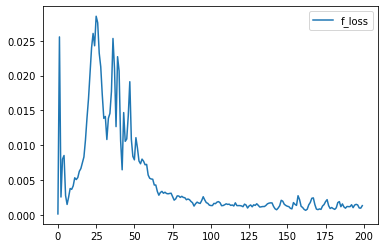

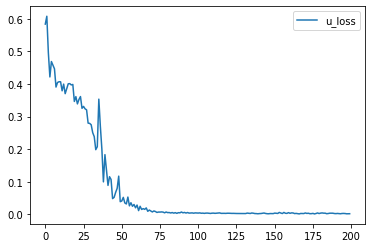

In [694]:
PINN_Trainer.train_network(256, epochs = 200, print_freq=500)

### plotting graph

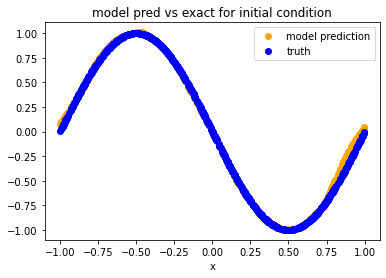

In [695]:
PINN_Trainer.plot_graph()

**`Exact solution is :`** $$\sin(\pi*(X - a*T)) $$

In [696]:
def plot_exact(net = Model1,n=1000,):

    X = ( ( torch.rand((n,1))*2 ) - 1 ).to(device)
    T = torch.rand((n,1)).to(device)

    input_data = torch.cat([X,T], dim = -1)
    pred = net.eval().to(device)(input_data).detach().cpu().numpy()
    truth = exact(X,T,0.1)

    print(F" R2 score of the model is : {r2_score(truth,pred)*100:.2f}%")

    plt.plot(truth, label = 'truth')
    plt.plot(pred, label = 'pred')
    plt.title('goodness of fit')
    plt.xlabel('truth')
    plt.ylabel('pred')
    plt.legend(loc = 'best')
    plt.show()

 R2 score of the model is : 99.71%


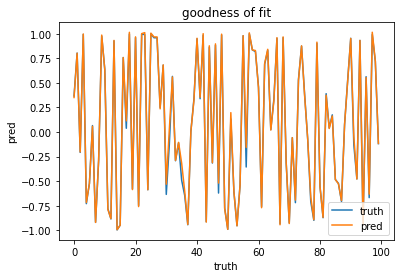

In [697]:
plot_exact(n = 100)

## Training Using Largaris method

### A ) making NN with a hidden layer with 10 neurons

In [698]:
class Lagaris_PINN_Model(nn.Module):
    
    def __init__(self, input_dim = 2, output_dim = 1):

        super(Lagaris_PINN_Model, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.dense_layer = nn.Sequential( 
            nn.Linear(self.input_dim, 10) , 
            nn.Tanh(), 

            nn.Linear(10,10),
            nn.Tanh(),

            nn.Linear(10, self.output_dim) )

    def forward(self, x):
       return self.dense_layer(x)

In [699]:
Lagaris_Network = Lagaris_PINN_Model().to(device)
print(f" total no of parameters in the model is : {sum([p.numel() for p in Lagaris_Network.parameters() if p.requires_grad ])*1e-3:.3f} K")

 total no of parameters in the model is : 0.151 K


**`Boundary condition :`**  

$ Ψ(0, y) = y^3 $

$ Ψ(1, y) = (1 + y^3)e^{−1}$

and 

$Ψ(x, 0) = xe^{−x}$ ,

$Ψ(x, 1) = e^{−x}(x + 1).$

**`Analytical Solution :`**  

$Ψ_{a}(x, y) = e^{−x}(x + y^3)$

**`Differential Equation:`**  

$∇^2Ψ(x, y) = e^{−x}(x − 2 + y^3 + 6y)$


### training with Lagaris Method

In [700]:
def exact_solution(X,Y): 
    X = X.detach().cpu().numpy()
    Y = Y.detach().cpu().numpy()
    a = lambda x,y : np.exp(-x)*(x + y**3)
    return a(X,Y)

def boundary_1(X,Y): 
    X = X.detach().cpu().numpy()
    Y = Y.detach().cpu().numpy()
    a = lambda x,y : np.exp(-x)*(x + y)
    return a(X,Y)

def boundary_2(X,Y):
    X = X.detach().cpu().numpy()
    Y = Y.detach().cpu().numpy() 
    a = lambda x,y : np.exp(-x)*(x + y**3)
    return a(X,Y)

def differential_target(X,Y): 
    X = X.detach().cpu().numpy()
    Y = Y.detach().cpu().numpy()
    a = lambda x,y : np.exp(-x)*(x - 2 + y**3 + 6*y)
    return a(X,Y)

In [864]:
def Neural_Network_sol(X,Y,net):

    pred = net.eval().to(device)(torch.cat([X,Y], dim = 1).to(device)).detach().cpu().numpy()

    X = X.detach().cpu().numpy()
    Y = Y.detach().cpu().numpy()

    A = lambda x,y : ( (1 - x)*(y**3) ) + (np.exp(-1)*(1 + y**3)*x) + ( (1 - y)*x*(np.exp(-x) - np.exp(-1))) + ( (1 + x)*np.exp(-x) - (1 - x - (2*x*np.exp(-1)) ))*y

    Final_Pred = A(X,Y) + (1-X)*X*(1-Y)*Y*(pred)
    return Final_Pred


In [755]:
def get_Lagaris_data(batch_size = 64):

    X = np.random.uniform(low = 0, high = 1, size = (batch_size, 1) )
    Y = np.random.uniform(low = 0, high = 1, size = (batch_size, 1) )
    # batched_data = np.concatenate( [x,y] , 1 )

    return Variable( torch.tensor(X, dtype = torch.float32), requires_grad = True ), Variable( torch.tensor(Y, dtype = torch.float32), requires_grad = True ),

In [892]:
A = lambda x,y : ( (1 - x)*(y**3) ) + (torch.exp(torch.tensor([-1]))*(1 + y**3)*x) + ( (1 - y)*x*(torch.exp(-x) - torch.exp(torch.tensor([-1])))) + ( (1 + x)*torch.exp(-x) - (1 - x - (2*x*torch.exp(torch.tensor([-1]))) ))*y
X,Y = get_Lagaris_data()
Z = A(X,Y)

In [893]:
dxx = torch.autograd.grad(Z, X, grad_outputs=torch.ones_like(Z), create_graph=True, )[0]
torch.autograd.grad(dxx, X,grad_outputs=torch.ones_like(dxx), create_graph=True, )

(tensor([[-0.2496],
         [-1.2326],
         [-0.6506],
         [-0.9604],
         [-0.5174],
         [-0.5368],
         [-0.5362],
         [-1.2599],
         [-1.8901],
         [-1.0899],
         [-0.4627],
         [-1.0723],
         [-0.1602],
         [-1.0698],
         [-0.8050],
         [-0.3201],
         [-0.8153],
         [-1.2438],
         [-1.0420],
         [-0.5147],
         [-0.8545],
         [-0.3314],
         [-1.5540],
         [-0.0175],
         [-0.1761],
         [-0.2800],
         [-0.6876],
         [-0.8324],
         [-0.8397],
         [-0.1727],
         [-0.4352],
         [-1.3747],
         [-0.6940],
         [-0.3056],
         [-0.2424],
         [-0.0593],
         [-0.5398],
         [-1.2026],
         [-0.6144],
         [-0.3059],
         [-0.7439],
         [-0.9904],
         [-0.6168],
         [-0.7034],
         [-0.9904],
         [-0.9835],
         [-0.3416],
         [-0.4980],
         [-0.4368],
         [-0.6950],


In [974]:
def Lagaris_Differential(X,Y, net):

    model_out = net(torch.cat([X,Y], dim = 1)) # the dependent variable u is given by the network based on independent variables x,t
    
    # print(u.shape, x.shape)
    t_1 = torch.tensor([1]).to(device)
    A = lambda x,y : ( (t_1 - x)*(y**3) ) + (torch.exp(t_1)*(1 + y**3)*x) + ( (t_1 - y)*x*(torch.exp(-x) - torch.exp(t_1))) + ( (t_1 + x)*torch.exp(-x) - (t_1 - x - (2*x*torch.exp(t_1)) ))*y
    u = A(X,Y) + (1-X)*X*(1-Y)*(Y)*model_out

    dx = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True, )[0]
    dx_2 = torch.autograd.grad(dx, X,grad_outputs=torch.ones_like(dx), create_graph=True, )[0]

    dy = torch.autograd.grad(u, Y, grad_outputs=torch.ones_like(u), create_graph=True, )[0]
    dy_2 = torch.autograd.grad(dy, Y, grad_outputs=torch.ones_like(dy), create_graph=True, )[0]
    # u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, allow_unused=True)

    # u_x = du[:,0]
    # u_t = du[:,1]

    target = differential_target(X,Y)

    # raise Exception(f"{( dx_2 + dy_2).shape}{dx_2}") # -> Passed

    pde =  dx_2 + dy_2
    return pde, target

In [975]:
Lagaris_Network = PINN_Model(n=15, hidden = 50)
# Lagaris_Network = Lagaris_PINN_Model()
print(f" total no of parameters in the model is : {sum([p.numel() for p in Lagaris_Network.parameters() if p.requires_grad ])*1e-3:.3f} K")

 total no of parameters in the model is : 83.385 K


In [976]:
lr = 5e-3
Lagaris_optimizer = torch.optim.Adam(Lagaris_Network.parameters(), lr = lr)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [977]:
class Lagaris_trainer():

    def __init__(self, model = Lagaris_Network, optimizer = Lagaris_optimizer, ):

        self.model = model.to(device)
        self.loss = nn.MSELoss()
        self.optimizer = optimizer
    
    def get_data(self,batch_size):

        data = get_Lagaris_data(batch_size)
        self.X = data[0]
        self.Y = data[1]
    
    def train_network(self, batch_size = 64, epochs = 20, print_freq = 10,):

        f_loss = []

        loop_obj = tqdm(range(epochs),)

        for e in loop_obj:

            self.get_data(batch_size = batch_size)
            
            # predictions
            pred_f = Lagaris_Differential( self.X.to(device), self.Y.to(device), self.model.to(device) )

            # calculating losses
            loss_f = self.loss(pred_f[0], torch.tensor(pred_f[1]).to(torch.float32).to(device) )

            total_loss = loss_f 

            # changing the desc in loop obj
            loop_obj.set_description(f" Train Loss is : {total_loss.item():.5f} ", refresh = True)

            # optimizer step
            self.optimizer.zero_grad()
            total_loss.backward()

            # print(self.model.dense_layer[0].weight.grad)
            # jj

            self.optimizer.step()

            # storing history
            f_loss.append(loss_f.item())

            if (e+1)% print_freq == 0 :
                    
                    print(f"\n=====================================================")
                    print(f" The current epoch is : {e+1} ")
                    print(f" F Loss is : {f_loss[-1]:.3f}")
                    print(f"=====================================================\n")

        plt.plot(f_loss, label = 'f_loss')
        plt.legend(loc = 'best')
        plt.show()
    
    def plot_graph(self, n = 1000):
         
        self.get_data(batch_size = n)
        X = self.X.to(device)
        Y = self.Y.to(device)

        pred_f = Lagaris_Differential( self.X.to(device), self.Y.to(device), self.model.to(device) )
        
        plt.figure(figsize = (20,12))
        plt.plot(pred_f[0].detach().cpu().numpy(),'o', label = 'model prediction', color = 'orange')
        plt.plot(pred_f[1], '*',label = 'truth', color = 'blue')
        plt.title('model pred vs exact for differentiation')
        plt.xlabel('number of input')
        plt.ylabel('prediction')
        plt.legend( loc = 'best' )
        plt.plot()
        plt.show()

        exact = exact_solution(X,Y)
        model_pred = Neural_Network_sol(X,Y,self.model)

        plt.figure(figsize = (20,12))
        plt.plot(model_pred, label = 'model prediction', color = 'orange')
        plt.plot(exact,label = 'truth', color = 'blue', alpha = 0.5)
        plt.title('model pred vs exact for differentiation as a continuous curve')
        plt.xlabel('number of input')
        plt.ylabel('prediction')
        plt.legend( loc = 'best' )
        plt.plot()
        plt.show()

        truth = exact_solution(X,Y)
        model_pred = Neural_Network_sol(X,Y,net = self.model)

### Training NN

In [978]:
Lagaris_NN_Trainer = Lagaris_trainer()

 Train Loss is : 0.34575 : 100%|██████████| 100/100 [00:13<00:00,  7.45it/s]


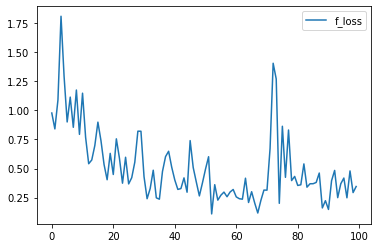

In [981]:
Lagaris_NN_Trainer.train_network(batch_size = 256*5, epochs = 100, print_freq = 500,)

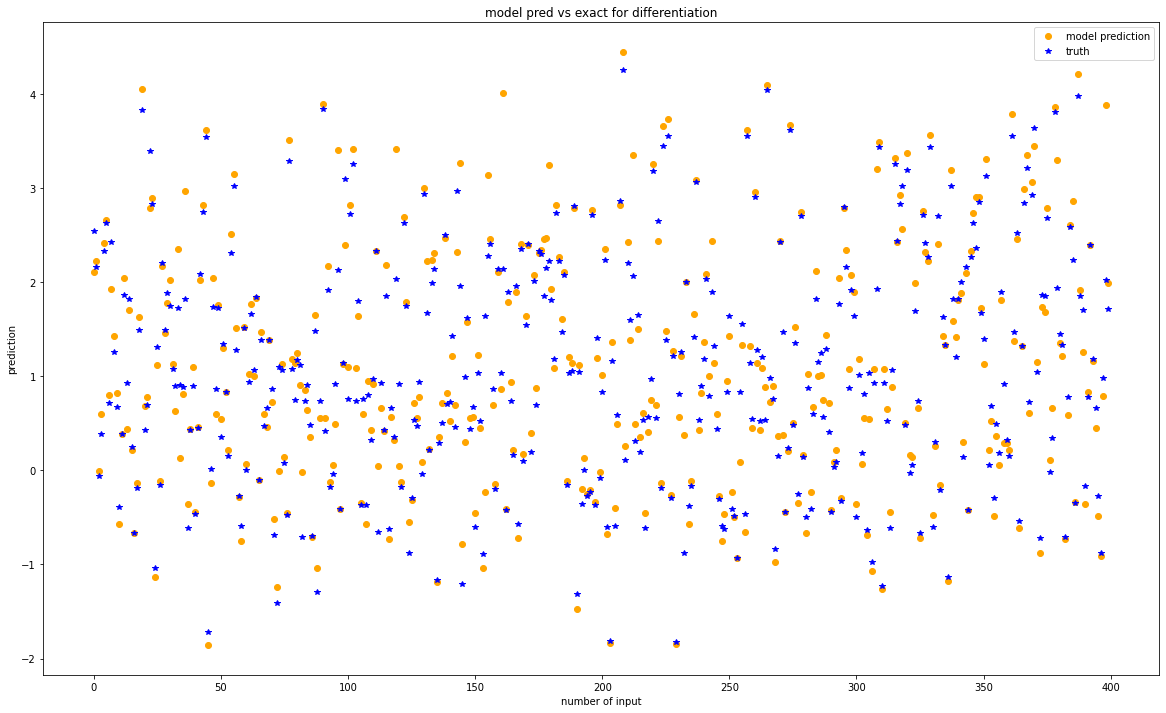

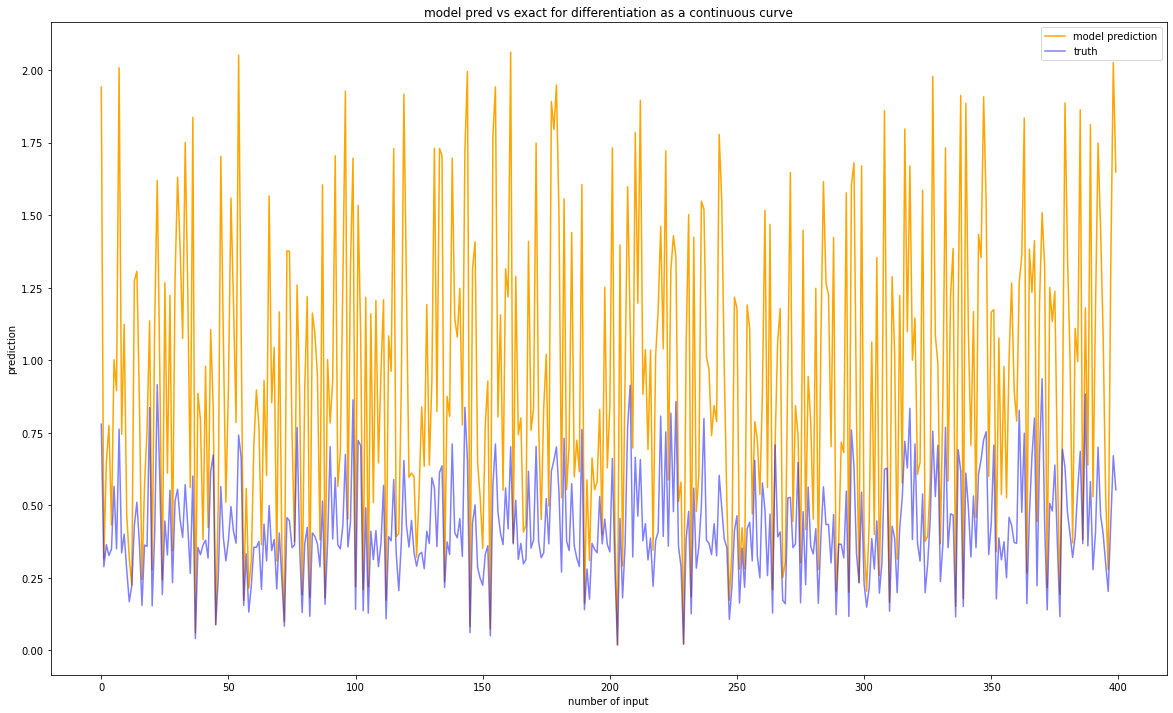

In [987]:
Lagaris_NN_Trainer.plot_graph(n = 400)

In [872]:
import sympy as sp
from sympy import symbols

In [882]:
p, q, n = symbols('p q n')

In [885]:
expr_A = ( (1 - p)*(q**3) ) + (sp.exp(-1)*(1 + q**3)*p) + ( (1 - q)*p*(sp.exp(-p) - np.exp(-1))) + ( (1 + p)*sp.exp(-p) - (1 - p - (2*p*sp.exp(-1)) ))*q
expr_B = (1-p)*p*(1-q)*q*n
expr_C = sp.exp(-p)*(p - 2 + p**3 + 6*p)

In [888]:
sp.simplify( expr_A.diff(p).diff(p)  + expr_A.diff(q).diff(q) - expr_C )

-p**3*exp(-p) - 6*p*q + 6*p*q*exp(-1) - 6*p*exp(-p) + 6*q + q*exp(-p)